# Checking only stats of mult Ns.

In [1]:
### Importing packages and functions
import sys
import os

In [2]:
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
# os.environ['AUTO_DIR'] = '/path2auto/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
import pickle

In [3]:
def saving_pdf_figure(fig,fig_name,md_dir):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    ax.savefig(fig_name+'.png',dpi=200)
    fig.savefig(pdffig, format="pdf")
    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [ ]:
from sympy.utilities.lambdify import lambdify
from numpy import linalg as LA
from copy import copy


### Defining neuron model

In [ ]:
## Loading neuron model (file in the cfg folder)
model_name='MTM_W_sPNAs_Temp_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name+'.json',strIapp=strIapp)


#  chapter 3: Network statistics

## Loading simulations for different Ko's and N's and extracting stats

In [ ]:
from scipy import signal
from scipy.fftpack import fft
import brian2
from brian2.units import *
from brian2 import *
from brianutils import load_model
resol=0.01#ms (min resolution of integration)
from brian2 import units
### For plotting the histograms...
import pandas as pd
import seaborn as sns

units = vars(units)


ge_amp=0.035
gi_amp=0.27
koivv=[8,9,10,11.0,12.0,12.5,13.0, 13.5]
si_v=[1.0]### sigma for white noise approximation..
i_siiv=0
koivv2=np.array(koivv)
# iapi_v=np.array(mu_fr_vect)

iapi_v=np.array([3.44756179, 3.09501356, 2.72745491, 2.34713872, 1.88336673,
       1.64088176, 1.31921738, 0.9238477 ])

# ### Will take as an example Ko 9.5 to see if the deltaU scales with T..
# 1. load network data
dir_SIMS=[]
# conds
time_stim=20000

##############################################################333
########### One Run..
model_file='/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'


m_prot_Ko=[]
m_prot_Iapp=[]
m_prot_N=[]
a_p_lfp_v=[]
a_f_lfp_v=[]
a_m_vv_corr_50pairs=[]
a_v_CV_pop=[]
a_v_CV_ii=[]
a_m_firing_rate=[]
a_m_corr_i=[]
a_v_FF_pop_a=[]
a_v_FF_pop_b=[]
a_m_Fano_factor=[]

v_num_neurons=[4000,6000,8000,12000]
# v_num_neurons=[4000,6000,8000]

for num_neurons in v_num_neurons:
    v_CV_pop=[]
    v_CV_ii=[]
    v_FF_pop=[]
    v_Fr_pop_a=[]
    v_Fr_pop_b=[]
    m_firing_rate=[]
    v_FF_pop_a=[]
    v_FF_pop_b=[]
    m_Fano_factor=[]
    m_corr0=[]
    m_corr_ij=[]
    m_corr_i=[]
    m_spk_count0=[]

    m_vv_corr_50pairs=[]
    v_m_ff=[]
    ckoi=0

    p_lfp_v=[]
    f_lfp_v=[]
    for K_o in koivv2:
        iapi=iapi_v[ckoi]
        bifparx={}

        ge_amp=0.035
        gi_amp=0.27
        ############# Creating Fancy name to understand simulations later
        num_runs=1
        ii_num_realizations_4_smooth=1
    #     num_neurons=4000
        bifparx["I_app"]=[str(iapi)+"* uA/cm2"]#0.87 for low and -0.68 For high to achieve ~10Hz Fr
        bifparx["K_o"]=["("+str(K_o)+"*mM)"]
        ############# Creating Fancy name to understand simulations later
        name='d_Network_N_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))
        iapp='I_app'
        ko='K_o'
        dir_pars=bifparx
        Koi_bifparx=float(dir_pars[ko][0][dir_pars[ko][0].index('(')+1:dir_pars[ko][0].index('*')])
        if Koi_bifparx-int(Koi_bifparx)==0:
            stringi=ko+'_'+str(int(Koi_bifparx))+'_'
        else:
            Koi_bifparx_aux=int((Koi_bifparx-int(Koi_bifparx))*100)
            stringi=ko+'_'+str(int(Koi_bifparx))+'_'+str(Koi_bifparx_aux)+'_'
        stringi=stringi+iapp+'_'+str(int(float(dir_pars[iapp][0][0:dir_pars[iapp][0].index('*')])*10))
        stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
        stringi=stringi+'pconnect_'+str(int(10.0))
        stringi=stringi+'_wZoomIn2Volt'
        stringi=stringi+'_multReal_num'+str(ii_num_realizations_4_smooth)+'wY_pres'
        name=name+stringi+'imprPresMas_5reals'
        dir_sims='/groups/susanne/Susana/Simulations/Network_trial/'
        if os.path.isfile(dir_sims+name+'.pkl'):
            print(name + ' Exists, or is being calculated.. :)')
            with open(dir_sims+name+'.pkl', "rb") as f:
                dir_i = pickle.load(f)
            
            m_corr_i_ii=[]
            p_lfp_v_i=[]
            f_lfp_v_i=[]
            for ii in range(len(dir_i)):
                print(dir_i[ii]['d_Protocol'])      
                v_ISI=dir_i[ii]['Spiking']['ISI']
                v_CV_pop.append(np.var(np.concatenate(v_ISI,axis=0))/(np.mean(np.concatenate(v_ISI,axis=0))**2))
                v_CV_ii.append([np.var(ii_ISI)/(np.mean(ii_ISI)**2) for ii_ISI in v_ISI]) 
                m_trains=dir_i[ii]['Spiking']['Trains']
                ### 1. for Firing rate per neuron
                tt_simtime=dir_i[ii]['Population_Rate']['t'][-1]-dir_i[ii]['Population_Rate']['t'][0]
                ttl=(tt_simtime)/1000.0## time in seconds to get rates in Hz
                Fr_pNeuron_v=[len(i_train)/ttl for i_train in m_trains]
                a0,b0=np.histogram(Fr_pNeuron_v, bins=np.linspace(0,60,60))
                m_firing_rate.append(Fr_pNeuron_v)
                v_Fr_pop_a.append(a0)
                v_Fr_pop_b.append(b0)
                ### 2. For FF
                m_ff={}
                for tt_wdsm in np.linspace(20,200,10):
        #             tt_wdsm=100;
                    m_ff[str(tt_wdsm)]=[]
                    num_wds=(dir_i[ii]['Population_Rate']['t'][-1]-dir_i[ii]['Population_Rate']['t'][0])/tt_wdsm
                    t00=dir_i[ii]['Population_Rate']['t'][0]
            #         v_spk_count=[[len(iij[(iij>tt_wdsm*iii+t00)*(iij<tt_wdsm*(iii+1)+t00)]) for iij in m_trains] for iii in range(int(num_wds))]
                    v_spk_count=[[len(iij[(iij>tt_wdsm*iii+t00)*(iij<tt_wdsm*(iii+1)+t00)]) for iii in range(int(num_wds))] for iij in m_trains] 
                    m_spk_count0=v_spk_count
                    a1,b1=np.histogram([np.var(ii_spk_count)/np.mean(ii_spk_count) for ii_spk_count in m_spk_count0], bins=np.linspace(0,10,50))
                    if tt_wdsm==100.0:
                        m_Fano_factor.append([np.var(ii_spk_count)/np.mean(ii_spk_count) for ii_spk_count in m_spk_count0])

                    v_FF_pop_a.append(a1)
                    v_FF_pop_b.append(b1)
                    v_spk_count=np.concatenate(v_spk_count)
                    #         v_spk_count=[len(iij) for iij in dir_i[ii]['Spiking']['Trains']]
                    v_FF_pop.append(np.var(v_spk_count)/(np.mean(v_spk_count)))
                    m_ff[str(tt_wdsm)]=[np.var(ii_spk_count)/np.mean(ii_spk_count) for ii_spk_count in m_spk_count0]

                ## 3. normalized Autocorrelation of population rate
                dt=1.0
                tt_autocorr=linspace(0,tt_simtime,int(tt_simtime/dt)+1)
                m_spk_times=np.zeros([len(dir_i[ii]['Spiking']['Trains']),len(tt_autocorr)])
                for i_trains,i_spikes in enumerate(dir_i[ii]['Spiking']['Trains']):
                    for ii_spike in i_spikes:
                        jti=int((ii_spike-t00)/dt)
                        m_spk_times[i_trains][jti]=m_spk_times[i_trains][jti]+1

                xxs=mean(m_spk_times,axis=0)
                corr_i=np.correlate(xxs-mean(xxs),xxs-mean(xxs),'full')
        #         corr_i=corr_i[int(corr_i.size/2):]      
                m_corr_i_ii.append(corr_i)
                ## 4. Distribution of correlations across pairs.. in 50ms time scales..
                dt=50.0
                tt_autocorrx=linspace(0,tt_simtime,int(tt_simtime/dt)+1)
                m_spk_times=np.zeros([len(dir_i[ii]['Spiking']['Trains']),len(tt_autocorrx)])
                for i_trains,i_spikes in enumerate(dir_i[ii]['Spiking']['Trains']):
                    for ii_spike in i_spikes:
                        jti=int((ii_spike-t00)/dt)
                        m_spk_times[i_trains][jti]=m_spk_times[i_trains][jti]+1

                frame_spkt=pd.DataFrame(np.transpose(m_spk_times),columns=range(np.shape(m_spk_times)[0]),index=[str(ii*dt)+'ms' for ii in range(np.shape(m_spk_times)[1])])
                corr_spktimes=frame_spkt[range(np.shape(m_spk_times)[0])].corr(method="pearson")
                vv=corr_spktimes.where(~np.triu(np.ones(corr_spktimes.shape)).astype(np.bool))
                vv=np.concatenate(vv)
                vv=vv[~isnan(vv)]
                m_vv_corr_50pairs.append(vv)
                ## 6. Power spectrum population rates
                tt=dir_i[ii]['Population_Rate']['t']
                x=dir_i[ii]['Population_Rate']['Freq_Pop']
                fs=len(x)/((tt[-1]-tt[0])/1000)
                sliding_window=int(fs/1.0)#To get a 2.0Hz resolution
                overlap = 0.0
                n_overlap = int(sliding_window * overlap)
                f_lfp, p_lfp = signal.welch(x-np.mean(x), fs,'flattop',nperseg=sliding_window, noverlap=n_overlap,scaling='spectrum')

                p_lfp_v_i.append(p_lfp)
                f_lfp_v_i.append(f_lfp)
                

                m_prot_Ko.append([K_o for iii in range(len(Fr_pNeuron_v))])
                m_prot_Iapp.append([iapi for iii in range(len(Fr_pNeuron_v))])
                m_prot_N.append([num_neurons for iii in range(len(Fr_pNeuron_v))])
                pass
            
            p_lfp_v.append(p_lfp_v_i)
            f_lfp_v.append(f_lfp_v_i)
            m_corr_i.append(m_corr_i_ii)
            
        else:
            ############# Running the network
            # try:
            dir_sim_i={}
        #     save_obj(dir_sim_i, dir_sims+name)
            m_vv_corr_50pairs.append([])
            m_firing_rate.append([])
            p_lfp_v.append([])
            f_lfp_v.append([])
            m_prot_Ko.append([])
            m_prot_Iapp.append([])
            m_prot_N.append([])
            v_CV_pop.append([])
            v_CV_ii.append([])
            m_corr_i.append([])
            m_Fano_factor.append([])
            print('this file doesnt exist.. :(  '+name)


        ckoi+=1
    
    a_m_vv_corr_50pairs.append(m_vv_corr_50pairs)
    a_m_firing_rate.append(m_firing_rate)
    a_p_lfp_v.append(p_lfp_v)
    a_f_lfp_v.append(f_lfp_v)
    a_v_CV_pop.append(v_CV_pop)
    a_v_CV_ii.append(v_CV_ii)
    a_m_corr_i.append(m_corr_i)
    a_m_Fano_factor.append(m_Fano_factor)

d_Network_N_4000_num_runs_1_lengthSim_20000K_o_8_I_app_34ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_5reals Exists, or is being calculated.. :)


WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
 [py.warnings]
WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
 [py.warnings]
WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scal

{'bifparx': {'I_app': ['3.44756179* uA/cm2'], 'K_o': ['(8.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}


WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in double_scalars
 [py.warnings]
WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in double_scalars
 [py.warnings]
WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in double_scalars
 [py.warnings]


{'bifparx': {'I_app': ['3.44756179* uA/cm2'], 'K_o': ['(8.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
{'bifparx': {'I_app': ['3.44756179* uA/cm2'], 'K_o': ['(8.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
{'bifparx': {'I_app': ['3.44756179* uA/cm2'], 'K_o': ['(8.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
{'bifparx': {'I_app': ['3.44756179* uA/cm2'], 'K_o': ['(8.0*mM)']}, 'num_neurons': 4000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
d_Network_N_4000_num_runs_1_lengthSim_20000K_o_9_I_app_30ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_5reals Exists, or is being calculate

{'bifparx': {'I_app': ['3.44756179* uA/cm2'], 'K_o': ['(8.0*mM)']}, 'num_neurons': 6000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
d_Network_N_6000_num_runs_1_lengthSim_20000K_o_9_I_app_30ge_3_gi_27pconnect_10_wZoomIn2Volt_multReal_num1wY_presimprPresMas_5reals Exists, or is being calculated.. :)
{'bifparx': {'I_app': ['3.09501356* uA/cm2'], 'K_o': ['(9.0*mM)']}, 'num_neurons': 6000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
{'bifparx': {'I_app': ['3.09501356* uA/cm2'], 'K_o': ['(9.0*mM)']}, 'num_neurons': 6000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}
{'bifparx': {'I_app': ['3.09501356* uA/cm2'], 'K_o': ['(9.0*mM)']}, 'num_neurons': 6000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.

{'bifparx': {'I_app': ['3.09501356* uA/cm2'], 'K_o': ['(9.0*mM)']}, 'num_neurons': 8000, 'model_file': '/home/contreras/Documents/Project_Adaptation/network_trial/cfg/MTM_W_sPNAs_Temp_snapshot_wSynInput.json'}


In [ ]:
a_m_Fano_factor_i=[]
a_m_firing_rate_i=[]
m_prot_Iapp_i=[]
m_prot_Ko_i=[]
m_prot_N_i=[]

m_prot_Iapp_icv=[]
m_prot_Ko_icv=[]
m_prot_N_icv=[]

m_prot_Iapp_icv_a=[]
m_prot_Ko_icv_a=[]
m_prot_N_icv_a=[]

av_a_m_corr_i=[]
av_a_p_lfp_v=[]
v_a_f_lfp_v=[]

v_CV_pop_iv=[]
a_v_CV_pop_iv=[]
a_v_CV_ii_iv=[]

cci=0
for uue in range(len(a_m_Fano_factor)):
    m_prot_Iapp_icv=[]
    m_prot_Ko_icv=[]
    m_prot_N_icv=[]
    v_CV_pop_iv=[]
    if np.shape(np.shape(a_m_Fano_factor[uue]))[0]==1:
        a_m_Fano_factor_i.append(a_m_Fano_factor[uue])
        a_m_firing_rate_i.append(a_m_firing_rate[uue])
        a_v_CV_ii_iv.append(a_v_CV_ii[uue])
        for ii_uue in range(np.shape(a_m_Fano_factor[uue])[0]):
            m_prot_Iapp_i.append(m_prot_Iapp[ii_uue+cci])
            m_prot_Ko_i.append(m_prot_Ko[ii_uue+cci])
            m_prot_N_i.append(m_prot_N[ii_uue+cci])
            
            try:
                m_prot_Iapp_icv.append(m_prot_Iapp[ii_uue+cci][0])
                m_prot_Ko_icv.append(m_prot_Ko[ii_uue+cci][0])
                m_prot_N_icv.append(m_prot_N[ii_uue+cci][0])
#                 if not np.isempty(a_v_CV_pop[uue][ii_uue+cci]):
                v_CV_pop_iv.append(a_v_CV_pop[uue][ii_uue])
            except:
                pass
            
        av_a_m_corr_iko=[]
        av_a_p_lfp_v_iko=[]
        for ii_ko in range(len(a_m_corr_i[uue])):
            av_a_m_corr_iko.append(np.mean(a_m_corr_i[uue][ii_ko],axis=0))
            av_a_p_lfp_v_iko.append(np.mean(a_p_lfp_v[uue][ii_ko],axis=0))
            
            
        av_a_m_corr_i.append(av_a_m_corr_iko)
        av_a_p_lfp_v.append(av_a_p_lfp_v_iko)
        v_a_f_lfp_v.append(a_f_lfp_v[uue][ii_ko][0])
        
        m_prot_Iapp_icv_a.append(m_prot_Iapp_icv)
        m_prot_Ko_icv_a.append(m_prot_Ko_icv)
        m_prot_N_icv_a.append(m_prot_N_icv)
        a_v_CV_pop_iv.append(v_CV_pop_iv)
            
        cci+=np.shape(a_m_Fano_factor[uue])[0]

data0=[np.concatenate(m_prot_N_i),np.concatenate(m_prot_Ko_i),np.concatenate(m_prot_Iapp_i),np.concatenate(np.concatenate(np.array(a_m_firing_rate_i))),np.concatenate(np.concatenate(np.array(a_m_Fano_factor_i))),np.concatenate(np.concatenate(np.array(a_v_CV_ii_iv)))]
df_stats = pd.DataFrame(columns=['N','K_o','I_app','Firing Rate','Fano Factor','CV'], data=np.array(data0).T)
df_stats['Firing Rate'] = df_stats['Firing Rate'].astype(float)
df_stats['Fano Factor'] = df_stats['Fano Factor'].astype(float)
df_stats['Fano Factor'].dropna().unique()
df_stats['CV'] = df_stats['CV'].astype(float)
df_stats['CV'].dropna().unique()

data1=[np.concatenate(m_prot_N_icv_a),np.concatenate(m_prot_Ko_icv_a),np.concatenate(m_prot_Iapp_icv_a),np.concatenate(a_v_CV_pop_iv)]
df_stats1 = pd.DataFrame(columns=['N','K_o','I_app','CV'], data=np.array(data1).T)
df_stats1['CV'] = df_stats1['CV'].astype(float)
df_stats1['K_o'] = df_stats1['K_o'].astype(float)


## Displaying stats: Comparing 2 extremes

In [10]:
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

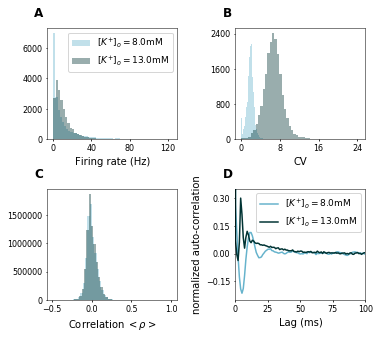

<Figure size 410.4x360 with 0 Axes>

In [11]:
### Add subplots with spiking statistics.. choose 2 cases to compare..
# 1. Firing rate distribution
# 2. Fano factor distribution
# 3. normalized Autocorrelation of population rate
# 4. Correlation in between pairs?
# 5. Distribution across the population
fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]



cmap=plt.get_cmap('ocean')
colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
try:
    del(f1,ax)
except:
    pass

# f1 = plt.figure(facecolor="1",figsize=(fig_wide*1.5,1.3*fig_height))
f1 = plt.figure(facecolor="1")
axp00 = plt.subplot2grid((12,12), (0, 0), colspan=5,rowspan=5)
axp01 = plt.subplot2grid((12,12), (0, 7), colspan=5,rowspan=5)
axp10 = plt.subplot2grid((12,12), (7, 0), colspan=5,rowspan=5)
axp11 = plt.subplot2grid((12,12), (7, 7), colspan=5,rowspan=5)
ax=np.array([[axp00,axp01],[axp10,axp11]])


i_N=0
num_neurons=v_num_neurons[i_N]

tt_corr_aux=list(np.sort(-tt_autocorr))+list(tt_autocorr)
colorii=next(colors)
colorii=next(colors)
for ikoi,K_o in enumerate(koivv2):
    colorii=next(colors)
    if K_o==8 or K_o==13:
#         sns.kdeplot(df_stats['Firing Rate'][df_stats['K_o']==K_o].dropna(), label='$K_o='+str(K_o)+'$mM',color=colorii,shade=True, ax=ax[0,0])
        sns.distplot(df_stats['Firing Rate'][df_stats['K_o']==K_o][df_stats['N']==num_neurons].dropna(),kde=False,hist_kws={"histtype": 'bar',"color": colorii}, label='$[K^{+}]_o='+str(K_o)+'$mM', ax=ax[0,0])
        df_stats['Firing Rate'][df_stats['K_o']==K_o][df_stats['N']==num_neurons].dropna().describe()
        ax[0,0].set_xlabel('Firing rate (Hz)')
        ax[0,0].legend()
#         g=sns.kdeplot(df_stats['Fano Factor'][df_stats['K_o']==K_o].dropna(), color=colorii,shade=True, ax=ax[0,1])
#         g.legend_.remove()
        g=sns.distplot(df_stats['CV'][df_stats['K_o']==K_o][df_stats['N']==num_neurons].dropna(), kde=False, hist_kws={"histtype": 'bar',"color": colorii},ax=ax[0,1])
        
        ax[0,1].set_xlabel('CV')
        
#         h=sns.kdeplot(m_vv_corr_50pairs[ikoi], color=colorii,shade=True, ax=ax[1,0])
        h=sns.distplot(a_m_vv_corr_50pairs[i_N][ikoi],kde=False,hist_kws={"histtype": 'bar' ,"color": colorii}, ax=ax[1,0])
        ax[1,0].set_xlabel(r'Correlation $ < \rho > $')
#         h.legend_.remove()

        ax[1,1].plot(tt_corr_aux[:-1],av_a_m_corr_i[i_N][ikoi]/np.max(av_a_m_corr_i[i_N][ikoi]),color=colorii,label='$[K^{+}]_o='+str(K_o)+'$mM')
        ax[1,1].set_xlabel('Lag (ms)')
        ax[1,1].set_ylabel('normalized auto-correlation')
        ax[1,1].set_xlim([0,100])
        ax[1,1].set_ylim([-0.25,0.35])
        ax[1,1].legend()



        
locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax[0,0].yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax[0,1].yaxis.set_major_locator(locatory2)
locatory3 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax[1,0].yaxis.set_major_locator(locatory3)
locatory4 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax[1,1].yaxis.set_major_locator(locatory4)


locatorx1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax[0,0].xaxis.set_major_locator(locatorx1)
locatorx2 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax[0,1].xaxis.set_major_locator(locatorx2)
locatorx3 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax[1,0].xaxis.set_major_locator(locatorx3)
locatorx4 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax[1,1].xaxis.set_major_locator(locatorx4)

import string
for n, axs in enumerate(ax.flat):   
    axs.text(-0.1, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, 
            size=matplotlib.rcParams["font.size"], weight='bold')
    
# f1.suptitle('N='+str(num_neurons))

fig_name='NetworkStatistics_cv_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_for2Kos'
iapp='I_app'
ko='K_o'
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
name=fig_name+stringi
fig_name='fig_'+fig_name



md_dir={}
md_dir['Title']='Network Statistics'+model_name+'Ko='+str(koivv2)+' for applied currents Iapp='+str(iapi_v)+' or whats needed to get 10Hz'
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='netowrk dynamics with stochastic bursting units'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'
iapi_v

saving_pdf_figure(f1,'./Figs/'+fig_name+'v2',md_dir)
f1.show()

In [12]:
fig_name

'fig_NetworkStatistics_cv_4000_num_runs_1_lengthSim_20000_for2Kos'

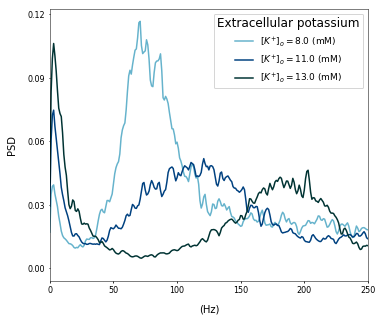

<Figure size 410.4x360 with 0 Axes>

In [14]:
# f11, ax= plt.subplots(1, sharex=True,sharey=True, facecolor="1",figsize=(fig_wide,fig_height))
f11, ax= plt.subplots(1, sharex=True,sharey=True, facecolor="1")
lxaxs=250


i_N=0

Spectrogram_Fr_v=v_a_f_lfp_v[i_N]
Spectrogram_v=av_a_p_lfp_v[i_N]

size_legend_font=20
cmap=plt.get_cmap('ocean')
colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
colorii=next(colors)
colorii=next(colors)
for koii in range(len(koivv2)):
    colorii=next(colors)
    if koii in [0,3,6]:
        ax.plot(Spectrogram_Fr_v, Spectrogram_v[koii],label='$[K^{+}]_o='+str(koivv2[koii])+'$ (mM)',color=colorii)
        ax.set_xlim([0,lxaxs])
#     print('Koi='+str(koiv[koii])+'# Neurons='+str(ii_num_neurons_v[koii])+' Peak Frequency: '+str(Spectrogram_Fr_v[koii][numneurjj][argmax(np.sqrt(Spectrogram_v[koii][numneurjj]))]))

# ax.set_title('Power spectral density of population rate')
ax.set_xlim([0,lxaxs])

# ax.legend(title='Extracellular potassium',loc='best', prop={'size': size_legend_font})
ax.legend(title='Extracellular potassium',loc='best')
# ax.set_xlabel('[Hz]',fontsize=size_axis_font,labelpad=10)
# ax.set_ylabel('PSD',fontsize=size_axis_font,labelpad=10)
ax.set_xlabel('(Hz)',labelpad=10)
ax.set_ylabel('PSD',labelpad=10)


locatory1 = MaxNLocator(nbins=5) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=5) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)

dir_figs='/home/contreras/Documents/Project_Adaptation/network_trial/Figs/'
name_file='PopulationActivity_averagePowerSpectrum_'+str(num_neurons)+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
iapp='I_app'
ko='K_o'
stringi=ko+'_'+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+'_'
stringi=stringi+iapp+'_'+str(int(float(bifparx[iapp][0][0:bifparx[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
name=name_file+stringi
fig_file_title='fig_'+name
md_dir={
        'Title':'PopulationActivity PowerSpectrum',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]))),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }
saving_pdf_figure(f11,'./Figs/'+fig_file_title+'v2',md_dir)
f11.show()

In [21]:
# f1, ax= plt.subplots(1,  facecolor="1",figsize=(fig_wide,fig_height))

# cmap=plt.get_cmap('Greys')
# colors=iter(cmap(np.linspace(1,0,len(v_num_neurons)+3)))

# colorii=next(colors)
# colorii=next(colors)
# for i_N in range(len(v_num_neurons)):
#     t_idxs=[ii for ii in range(len(np.array(a_v_CV_pop[i_N]))) if a_v_CV_pop[i_N][ii]]
#     ax.plot(koivv2[t_idxs],np.array(a_v_CV_pop[i_N])[t_idxs],'o',markersize=15,color=colorii,label='N='+str(v_num_neurons[i_N]))
#     colorii=next(colors)

# ax.set_xlabel(r'Extracellular potassium $[K_o]^+$',fontsize=size_axis_font)
# ax.set_ylabel(r'CV',fontsize=size_axis_font)
# ax.legend()

# fig_name='CV_NetworkStatistics'+'_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_forallKos'+'_forMultNs'
# iapp='I_app'
# ko='K_o'
# stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
# name=fig_name+stringi
# fig_name='fig_'+fig_name

# md_dir={}
# md_dir['Title']='CV from Network Statistics for mult Ns'+model_name+'Ko='+str(koivv2)+' for applied currents Iapp='+str(iapi_v)+' or whats needed to get 10Hz'
# md_dir['Author']= 'Susana Contreras'
# md_dir['Subject']='netowrk dynamics with stochastic bursting units'
# md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'
# iapi_v

# # saving_pdf_figure(f1,'./Figs/'+fig_name,md_dir)
# saving_pdf_figure(f1,'./Figs/'+fig_name,md_dir)

In [22]:
fig_name

'fig_NetworkStatistics_cv_4000_num_runs_1_lengthSim_20000_for2Kos'

In [17]:
v_num_neurons

[4000, 6000, 8000, 12000]

3.0000015000007494
3.0000015000007494
3.0000015000007494
4.0000020000009995
3.0000015000007494
5.00000250000125
3.0000015000007494
3.0000015000007494


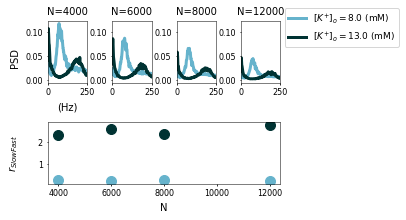

<Figure size 410.4x360 with 0 Axes>

In [18]:
lxaxs=250

v_num_neurons_ii=v_num_neurons
f11 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*0.6))
# f11 = plt.figure(facecolor="1",figsize=(7.5,5.0))
ax=[]
# for i_N in range(len(v_num_neurons_ii)):
#     if i_N==0:
#         ax.append(plt.subplot2grid((3*len(v_num_neurons_ii)+3,3*len(v_num_neurons_ii)), (0, i_N*3), colspan=2,rowspan=2))
#     else:
#         ax.append(plt.subplot2grid((3*len(v_num_neurons_ii)+3,3*len(v_num_neurons_ii)), (0, i_N*3),sharey=ax[0], colspan=2,rowspan=2))
    
# ax.append(plt.subplot2grid((3*len(v_num_neurons_ii)+3,3*len(v_num_neurons_ii)), (3, 0), colspan=3*len(v_num_neurons_ii)-1,rowspan=2))    

for i_N in range(len(v_num_neurons_ii)):
    if i_N==0:
        ax.append(plt.subplot2grid((5,3*len(v_num_neurons_ii)+3), (0, i_N*3), colspan=2,rowspan=2))
    else:
        ax.append(plt.subplot2grid((5,3*len(v_num_neurons_ii)+3), (0, i_N*3),sharey=ax[0], colspan=2,rowspan=2))
    
ax.append(plt.subplot2grid((5,3*len(v_num_neurons_ii)+3), (3, 0), colspan=3*len(v_num_neurons_ii)-1,rowspan=2))


a_v_ratio=[]
for i_N in range(len(v_num_neurons_ii)):
    Spectrogram_Fr_v=v_a_f_lfp_v[i_N]
    Spectrogram_v=av_a_p_lfp_v[i_N]
    size_legend_font=20
    cmap=plt.get_cmap('ocean')
    colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
    colorii=next(colors)
    colorii=next(colors)
    v_ratio=[]
    for koii in range(len(koivv2)):
        colorii=next(colors)
        if koii in [0,6]:
            ax[i_N].plot(Spectrogram_Fr_v, Spectrogram_v[koii],label='$[K^{+}]_o='+str(koivv2[koii])+'$ (mM)',color=colorii,linewidth=3)
            ax[i_N].set_xlim([0,lxaxs])
            slw_peak=max(Spectrogram_v[koii][Spectrogram_Fr_v<6])
            print(Spectrogram_Fr_v[argmax(Spectrogram_v[koii][Spectrogram_Fr_v<6])])
            fst_peak=max(Spectrogram_v[koii][(Spectrogram_Fr_v>50)*(Spectrogram_Fr_v<lxaxs)])
            v_ratio.append(slw_peak/fst_peak)
            
    a_v_ratio.append(v_ratio)
    ax[i_N].set_xlim([0,lxaxs])
    ax[i_N].set_title('N='+str(v_num_neurons_ii[i_N]))
    
# ax[0].set_ylabel('PSD',fontsize=size_axis_font,labelpad=10)
# ax[0].set_xlabel('Hz',fontsize=size_axis_font,labelpad=10)
ax[0].set_ylabel('PSD',labelpad=5)
ax[0].set_xlabel('(Hz)',labelpad=5)


# ax[len(v_num_neurons)-1].set_xlabel('[Hz]',fontsize=size_axis_font,labelpad=10)


cmap=plt.get_cmap('ocean')
colors=iter(cmap(np.linspace(1,0,len(koivv2)+3)))
colorii=next(colors)
colorii=next(colors)
cc=0
for koii in range(len(koivv2)):
    colorii=next(colors)
    if koii in [0,6]:
        ax[len(v_num_neurons_ii)].plot(v_num_neurons_ii, np.array(a_v_ratio).T[cc],'o',markersize=10, label='$[K^{+}]_o='+str(koivv2[koii])+'$mM',color=colorii)
        cc+=1

# ax[len(v_num_neurons_ii)].set_xlabel('N',fontsize=size_axis_font,labelpad=10)
# ax[len(v_num_neurons_ii)].set_ylabel(r'$r_{SlowFast}$',fontsize=size_axis_font,labelpad=10)
ax[len(v_num_neurons_ii)].set_xlabel('N',labelpad=5)
ax[len(v_num_neurons_ii)].set_ylabel(r'$r_{SlowFast}$',labelpad=5)


# ax[len(v_num_neurons_ii)-1].legend(title='Extracellular potassium',loc='best', bbox_to_anchor=(1, 1),prop={'size': size_legend_font})
# ax[len(v_num_neurons_ii)-1].legend(loc='best', bbox_to_anchor=(1, 0.5),prop={'size': size_legend_font})
ax[len(v_num_neurons_ii)-1].legend(loc='best', bbox_to_anchor=(1, 0.5))



# locatory1 = MaxNLocator(nbins=5) # with 3 bins you will have 4 ticks
# ax.yaxis.set_major_locator(locatory1)
locatorx1 = MaxNLocator(nbins=5) # with 3 bins you will have 4 ticks
ax[len(v_num_neurons_ii)].xaxis.set_major_locator(locatorx1)

############################################
### Aligning y labels
############################################
labely = -0.12  # axes coords
boxP =ax[len(v_num_neurons_ii)].get_position()
box0p =ax[0].get_position()
ax[len(v_num_neurons_ii)].yaxis.set_label_coords(labely, 0.5)
ax[0].yaxis.set_label_coords(boxP.width/box0p.width*labely, 0.4)



dir_figs='/home/contreras/Documents/Project_Adaptation/network_trial/Figs/'
name_file='PopulationActivity_PowerSpectrum__num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
iapp='I_app'
ko='K_o'
stringi=ko+'_'+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+'_'
stringi=stringi+iapp+'_'+str(int(float(bifparx[iapp][0][0:bifparx[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
name=name_file+stringi+'_multNs'
fig_file_title='fig_'+name
md_dir={
        'Title':'PopulationActivity PowerSpectrum',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]))),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }

saving_pdf_figure(f11,'./Figs/'+fig_file_title,md_dir)

f11.show()

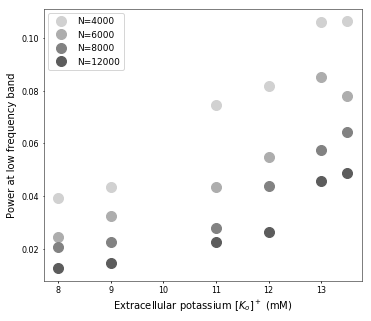

<Figure size 410.4x360 with 0 Axes>

In [19]:
f1, ax= plt.subplots(1, sharex=True, facecolor="1",figsize=(fig_wide,fig_height))

# lxaxis=100

cmap=plt.get_cmap('Greys_r')
colors=iter(cmap(np.linspace(1,0,len(v_num_neurons_ii)+4)))

colorii=next(colors)
colorii=next(colors)
colorii=next(colors)
for i_N in range(len(v_num_neurons_ii)):
    Spectrogram_Fr_v=v_a_f_lfp_v[i_N]
    Spectrogram_v=av_a_p_lfp_v[i_N]
    psd_v=[]
    kovvii=[]
    for koii in range(len(koivv2)):
        if len(Spectrogram_Fr_v)>0:
            try:
                psd_v.append(max(Spectrogram_v[koii][Spectrogram_Fr_v<50]))
                kovvii.append(koivv2[koii])
            except:
                psd_v.append(np.nan)
                kovvii.append(koivv2[koii])
        
    ax.plot(kovvii,psd_v,'o',markersize=10,color=colorii,label='N='+str(v_num_neurons[i_N]))
    colorii=next(colors)



# ax.legend(loc='best', bbox_to_anchor=(1, 0.5),prop={'size': size_legend_font})
ax.legend(loc='best')
ax.set_ylabel('Power at low frequency band')
ax.set_xlabel(r'Extracellular potassium $[K_o]^+$ (mM)')

dir_figs='/home/contreras/Documents/Project_Adaptation/network_trial/Figs/'
name_file='lowFrequencies_PowerSpectrum_MultNs_num_runs_'+str(1)+'_lengthSim_'+str(int(time_stim))+'_'
iapp='I_app'
ko='K_o'
stringi=ko+'_'+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')])))+'_'
stringi=stringi+iapp+'_'+str(int(float(bifparx[iapp][0][0:bifparx[iapp][0].index('*')])*10))
stringi=stringi+'ge_'+str(int(ge_amp*100))+'_gi_'+str(int(gi_amp*100))
name=name_file+stringi
fig_file_title='fig_'+name
md_dir={
        'Title':'PopulationActivity PowerSpectrum low frequency band 2-6Hz',
        'Author':"Susana Contreras 25/02/2019",
        'Subject':'Network simulation '+str(num_neurons)+' neurons snapshot with Ko='+str(int(float(bifparx[ko][0][bifparx[ko][0].index('(')+1:bifparx[ko][0].index('*')]))),
        'Keywords':"Ko bistability, network synchronization, SNIC, SNL"
        }


saving_pdf_figure(f1,'./Figs/'+fig_file_title,md_dir)

